## **Binary Prediction**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import matthews_corrcoef
from xgboost import XGBClassifier
import category_encoders as ce
from xgboost import XGBRegressor
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
url_train='train.csv'
url_test='test.csv'
train=pd.read_csv(url_train,sep=',')
test=pd.read_csv(url_test,sep=',')
print(train.shape)
print(test.shape)

(3116945, 22)
(2077964, 21)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [4]:
# Valores nulos 
train.isnull().sum()

id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

Columns in train with more than 10% missing values
cap-diameter             0.000128
cap-shape                0.001283
cap-surface             21.528227
cap-color                0.000385
does-bruise-or-bleed     0.000257
gill-attachment         16.809280
gill-spacing            40.373988
gill-color               0.001829
stem-root               88.452732
stem-surface            63.551362
stem-color               0.001219
veil-type               94.884350
veil-color              87.936970
has-ring                 0.000770
ring-type                4.134818
spore-print-color       91.425482
habitat                  0.001444
dtype: float64

Columns in df_test with more than 10% missing values:
cap-diameter             0.000337
cap-shape                0.001492
cap-surface             21.506821
cap-color                0.000626
does-bruise-or-bleed     0.000481
gill-attachment         16.834796
gill-spacing            40.404694
gill-color               0.002358
stem-height              0.00

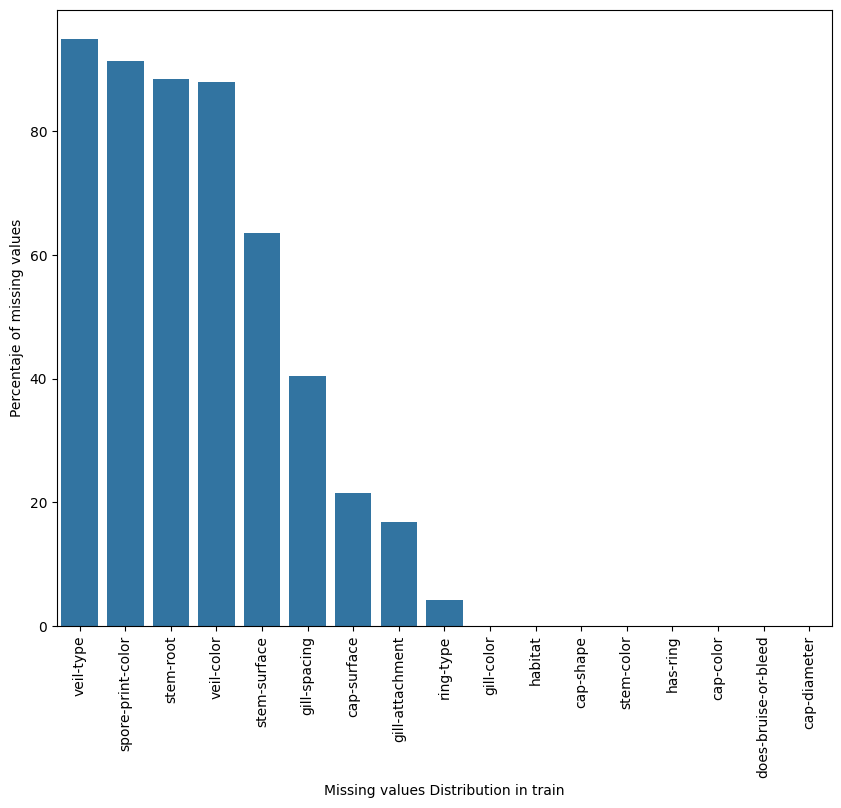

In [5]:
missing_train=train.isna().mean()*100
missing_test=test.isna().mean()*100
print("Columns in train with more than 10% missing values")
print(missing_train[missing_train>0])
print("\nColumns in df_test with more than 10% missing values:")
print(missing_test[missing_test>0])

missing_values=train.isnull().mean()*100
missing_values=missing_values[missing_values>0]
missing_values=missing_values.sort_values(ascending=False)
plt.figure(figsize=(10,8))
sns.barplot(x=missing_values.index,y=missing_values.values)
plt.xticks(rotation='vertical')
plt.ylabel('Percentaje of missing values')
plt.xlabel('Missing values Distribution in train')
plt.show()

In [6]:
# Valores unicos
train.nunique()

id                      3116945
class                         2
cap-diameter               3913
cap-shape                    74
cap-surface                  83
cap-color                    78
does-bruise-or-bleed         26
gill-attachment              78
gill-spacing                 48
gill-color                   63
stem-height                2749
stem-width                 5836
stem-root                    38
stem-surface                 60
stem-color                   59
veil-type                    22
veil-color                   24
has-ring                     23
ring-type                    40
spore-print-color            32
habitat                      52
season                        4
dtype: int64

In [7]:
# Drop id
train=train.drop(columns=['id'])
test=test.drop(columns=['id'])

class
p    1705396
e    1411549
Name: count, dtype: int64


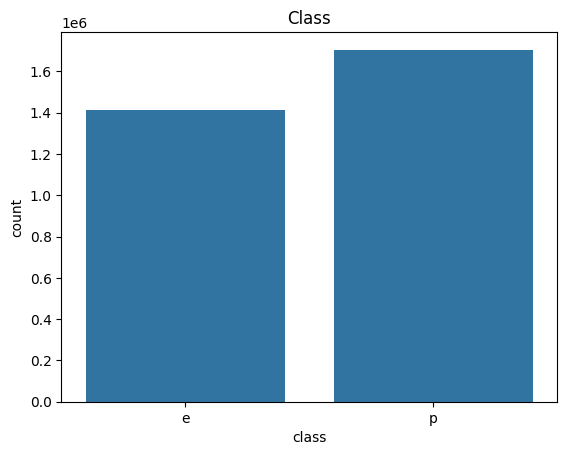

In [8]:
# Target 
print(train['class'].value_counts())
sns.countplot(data=train,x='class')
plt.title('Class')
plt.show()

In [9]:
missing_threshold = 0.80
high_missing_columns = train.columns[train.isnull().mean() > missing_threshold]
high_missing_columns

Index(['stem-root', 'veil-type', 'veil-color', 'spore-print-color'], dtype='object')

In [10]:
train=train.drop(columns=high_missing_columns)
test=test.drop(columns=high_missing_columns)
target='class'
for column in train.columns:
    if train[column].isnull().any():      
        if train[column].dtype == 'object':
            mode_value = train[column].mode()[0]
            train[column].fillna(mode_value, inplace=True)
            test[column].fillna(mode_value, inplace=True)     
        else:
            median_value = train[column].median()
            train[column].fillna(median_value, inplace=True)
            test[column].fillna(median_value, inplace=True)

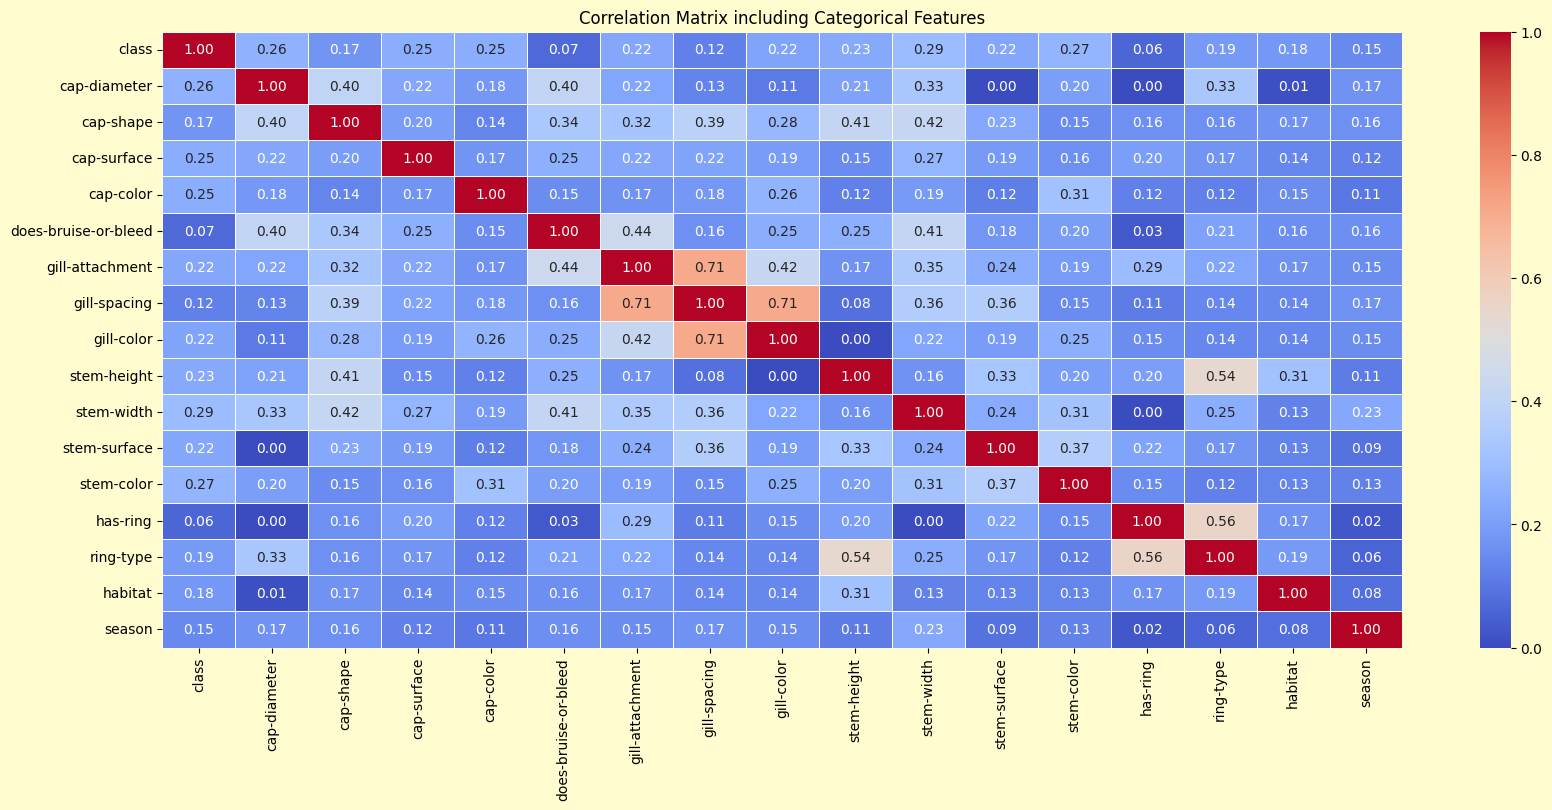

In [11]:
from dython.nominal import associations
associations_df = associations(train[:10000], nominal_columns='all', plot=False)
corr_matrix = associations_df['corr']
plt.figure(figsize=(20, 8))
plt.gcf().set_facecolor('#FFFDD0') 
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()

In [12]:
cols_to_drop_train=missing_train[missing_train>85].index
cols_to_drop_test = missing_test[missing_test >85].index
print(cols_to_drop_train)
print(cols_to_drop_test)

Index(['stem-root', 'veil-type', 'veil-color', 'spore-print-color'], dtype='object')
Index(['stem-root', 'veil-type', 'veil-color', 'spore-print-color'], dtype='object')


In [13]:
def knn_impute(df, n_neighbors=5):   
    df_encoded = df.copy()
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_encoded), columns=df_encoded.columns)
    for col in df.select_dtypes(include='object').columns:
        df_imputed[col] = df_imputed[col].round().astype(int).map(
            dict(enumerate(df[col].astype('category').cat.categories)))
    return df_imputed

In [14]:
df_train_imputed=knn_impute(train,n_neighbors=5)
df_test_imputed=knn_impute(test,n_neighbors=5)

In [15]:
print(test.columns)

Index(['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-surface', 'stem-color', 'has-ring',
       'ring-type', 'habitat', 'season'],
      dtype='object')


In [16]:
print(train.columns)

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-surface', 'stem-color', 'has-ring',
       'ring-type', 'habitat', 'season'],
      dtype='object')


In [17]:
cat_cols_train=df_train_imputed.select_dtypes(include=['object']).columns
#print(cat_cols_train)
cat_cols_train=cat_cols_train[cat_cols_train!='class']
ordinal_encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df_train_imputed[cat_cols_train] = ordinal_encoder.fit_transform(df_train_imputed[cat_cols_train].astype(str))
df_test_imputed[cat_cols_train] = ordinal_encoder.transform(df_test_imputed[cat_cols_train].astype(str))

In [18]:
df_train=df_train_imputed.copy()
df_test=df_test_imputed.copy()

In [19]:
le=LabelEncoder()
df_train['class']=le.fit_transform(df_train['class'])
y=df_train['class']
X=df_train.drop(['class'],axis=1)

In [20]:
def mcc_metric(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred = (y_pred > 0.5).astype(int) 
    mcc = matthews_corrcoef(y_true, y_pred)
    return 'mcc', mcc

In [21]:
train_X, test_X, train_y, test_y = train_test_split(X, y,test_size = 0.2, random_state =42,stratify=y)

# **Model XGBCLASSIFIER**

In [22]:
model = XGBClassifier(                    
    alpha=0.1,                   
    subsample=0.8,     
    colsample_bytree=0.6,  
    objective='binary:logistic',
    max_depth=14,             
    min_child_weight=7,         
    gamma=1e-6,                
    #random_state=42,                 
    n_estimators=100
    )
XGB = model.fit(
    train_X, 
    train_y, 
    eval_set=[(test_X, test_y)],
    eval_metric=mcc_metric)


[0]	validation_0-logloss:0.45752	validation_0-mcc:0.93695
[1]	validation_0-logloss:0.32708	validation_0-mcc:0.96835
[2]	validation_0-logloss:0.24747	validation_0-mcc:0.97233
[3]	validation_0-logloss:0.19832	validation_0-mcc:0.97361
[4]	validation_0-logloss:0.16465	validation_0-mcc:0.97524
[5]	validation_0-logloss:0.13424	validation_0-mcc:0.97567
[6]	validation_0-logloss:0.11363	validation_0-mcc:0.97651
[7]	validation_0-logloss:0.09723	validation_0-mcc:0.97674
[8]	validation_0-logloss:0.08314	validation_0-mcc:0.97805
[9]	validation_0-logloss:0.07428	validation_0-mcc:0.97852
[10]	validation_0-logloss:0.06673	validation_0-mcc:0.97900
[11]	validation_0-logloss:0.06024	validation_0-mcc:0.97959
[12]	validation_0-logloss:0.05633	validation_0-mcc:0.97981
[13]	validation_0-logloss:0.05357	validation_0-mcc:0.98000
[14]	validation_0-logloss:0.05055	validation_0-mcc:0.98028
[15]	validation_0-logloss:0.04762	validation_0-mcc:0.98067
[16]	validation_0-logloss:0.04585	validation_0-mcc:0.98087
[17]	va

In [23]:
y_pred = XGB.predict(test_X)

In [24]:
score = matthews_corrcoef(test_y, y_pred)
print('MCC:', round(score*100,2), '%')

MCC: 98.27 %


In [25]:
test_pred_prob=XGB.predict(df_test)

In [26]:
test_pred_class=le.inverse_transform(test_pred_prob)

In [27]:
sub='sample_submission.csv'
df_sub=pd.read_csv(sub,sep=',')
df_sub.head()

,id,class
0,3116945,e
1,3116946,e
2,3116947,e
3,3116948,e
4,3116949,e


In [28]:
df_sub['class']= test_pred_class

In [29]:
df_sub.to_csv('submission.csv', index = False)
pd.read_csv('submission.csv')

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
...,...,...
2077959,5194904,p
2077960,5194905,p
2077961,5194906,p
2077962,5194907,e


In [30]:
df_sub['class'].value_counts()

class
p    1133407
e     944557
Name: count, dtype: int64

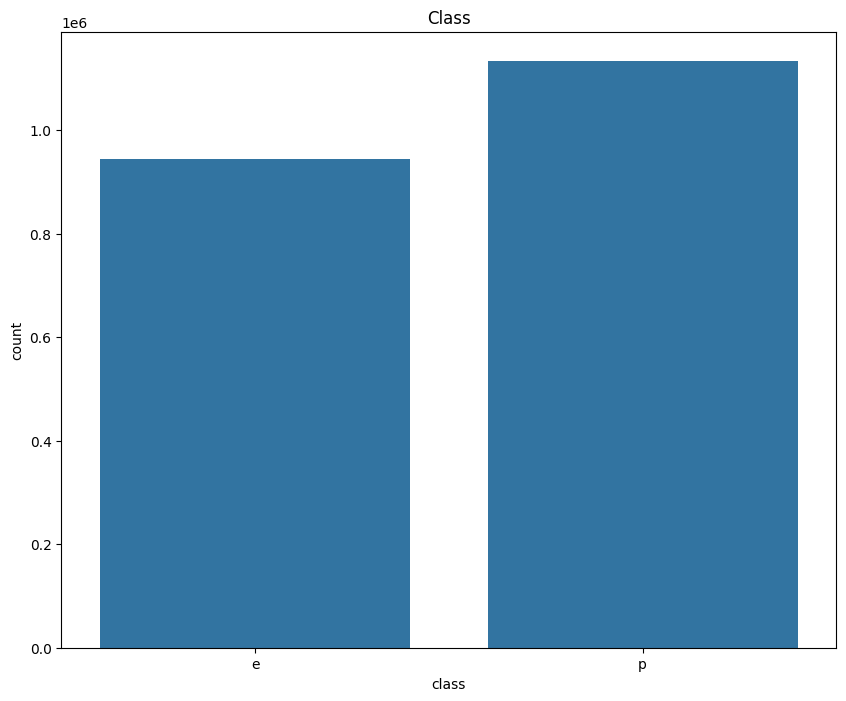

In [31]:
plt.figure(figsize=(10,8))
sns.countplot(data=df_sub,x='class')
plt.title('Class',fontsize=12)
plt.show()